# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

## Funções de suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
jupyter_settings()

In [3]:
def eval_wss(x, clusters, random_state=73):
    wss = []
    for k in clusters:
        model = KMeans(init = 'random',
                       n_clusters = k,
                       max_iter = 300,
                       random_state = random_state)
        model.fit(x)
        wss.append(model.inertia_)
    return wss

def eval_ss(x, clusters, random_state=73):
    ss = []
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=random_state)
        pred = model.fit_predict(x)
        score = silhouette_score(x, pred, metric='euclidean')
        ss.append(score)
    return ss

## Importar dados

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'latin1')

df_raw.drop('Unnamed: 8', axis = 1, inplace = True)

# 1 Descrição dos dados

In [20]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [21]:
cols = ['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

In [22]:
df1.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

**invoice:** Invoice number (A 6-digit integral number uniquely assigned to each transaction)

**stock_code:** Product (item) code

**description:** Product (item) name

**quantity:** The quantities of each product (item) per transaction

**invoice_date:** The day when each transaction was generated

**unit_price:** Unit price (Product price per unit)

**customer_id:** Customer number (Unique ID assigned to each customer)

**country:** Country name (The name of the country where each customer resides)

## 1.2 Dimensão dos dados

In [23]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de colunas: 8


## 1.3 Tipo dos dados

In [24]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

In [9]:
df1.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4 Tratar os NAs

In [10]:
df1['description'].fillna('-', inplace = True)
df1.dropna(inplace = True)

In [13]:
print('Dados removidos: {:.1f}%'.format(100*(1-df1.shape[0]/df_raw.shape[0])))
print('Número de linhas: {}'.format(df1.shape[0]))

Dados removidos: 24.9%
Número de linhas: 406829


In [14]:
df1.isna().sum()

invoice         0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 Estatística descritiva

In [13]:
num_attributes = df1[['quantity', 'unit_price']]
cat_attributes = df1[['invoice', 'stock_code', 'customer_id', 'country']]

### 1.5.1 Atributos numéricos

In [14]:
# Tendência central - média, mediana
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contatenar
m = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988


### 1.5.2 Atributos categóricos

In [15]:
cat_attributes.apply(lambda x: len(x.unique()))

invoice        22190
stock_code      3684
customer_id     4372
country           37
dtype: int64

array([[<AxesSubplot:title={'center':'customer_id'}>]], dtype=object)

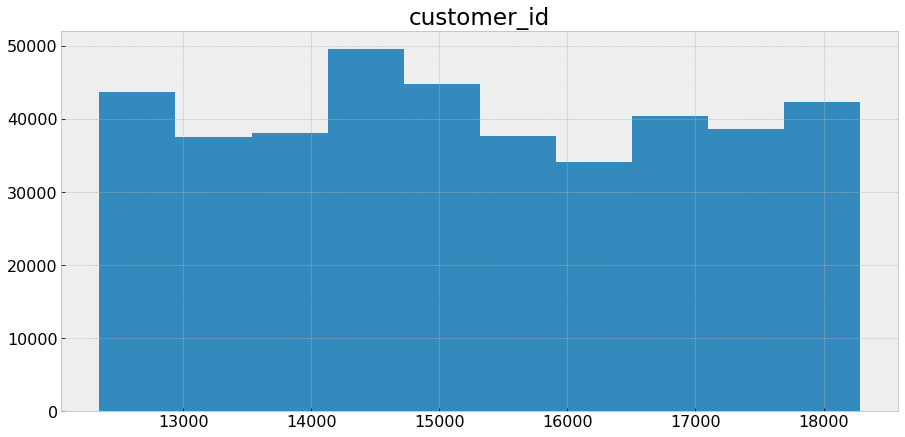

In [16]:
cat_attributes.hist()

<AxesSubplot:>

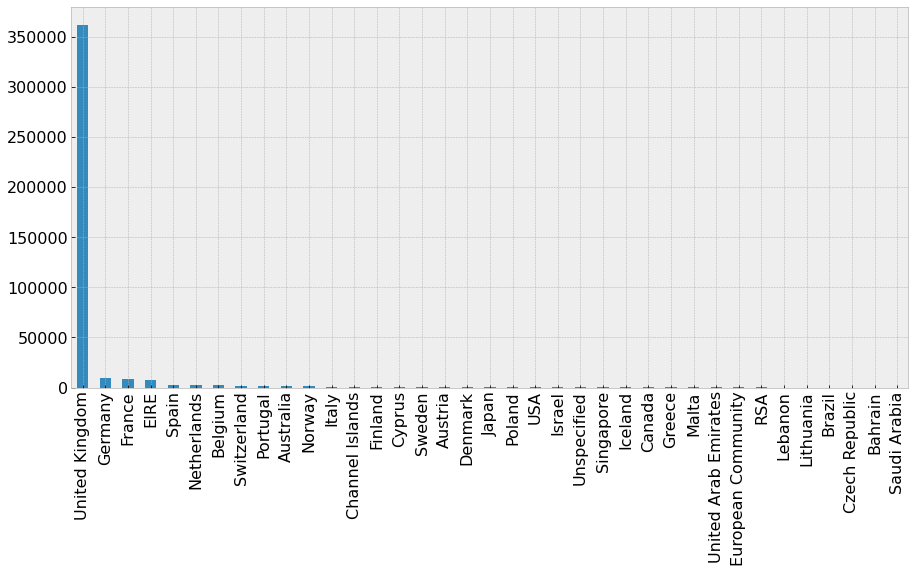

In [17]:
cat_attributes['country'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

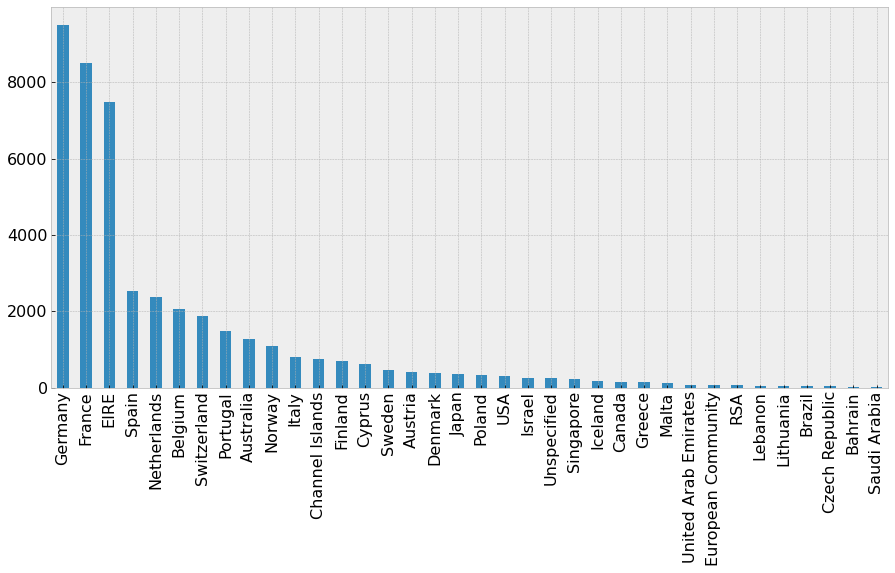

In [18]:
cat_attributes[cat_attributes['country'] != 'United Kingdom']['country'].value_counts().plot(kind = 'bar')

## 1.6 Outliers

In [24]:
# Invoices 541431 e 581483 parecem ser erros
customers = [16446, 12346]
df1[df1['customer_id'].isin(customers)]

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2017-01-16,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,12346.0,United Kingdom
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,16446.0,United Kingdom
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,16446.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,16446.0,United Kingdom


In [33]:
df1.drop([61619, 61624, 540421, 540422], inplace = True)

80995

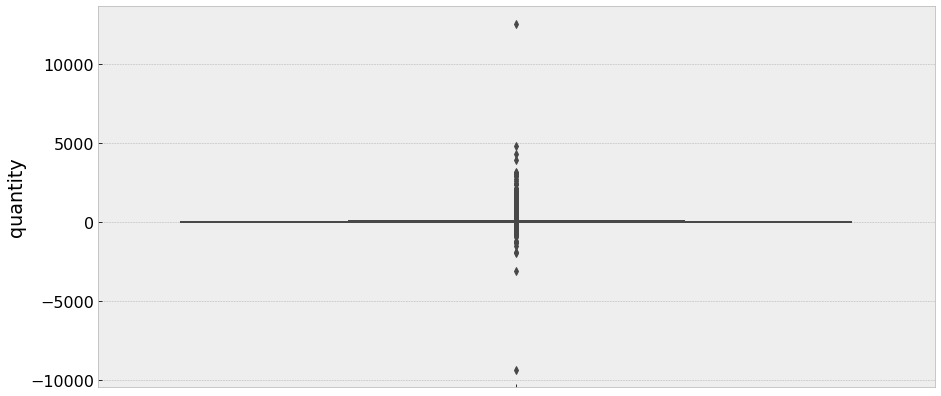

In [26]:
sns.boxplot(data = aux, y = 'quantity')
df1['quantity'].max()

# 2 Feature engineering

## Data checkpoint

In [25]:
df2 = df1.copy()

In [35]:
df2.to_csv('../data/interim/c1_df2.csv', index = False)

In [37]:
df2 = pd.read_csv('../data/interim/c1_df2.csv')
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])

## 2.1 Criação das variáveis

**customer_id:** customer identification

**volume:** total amount spend by customer so far

**frequency:** number of purchases

**recency:** time since last purchase

**mean_recency:** average interval between purchases

**low_purch:** lowest purchase value

**high_purch:** highest purchase value

**returns:** number of purchases where at least one product was returned

**mean_basket_size:** average number of items per purchase

**country:** customer's country of residence

In [38]:
# Total price
df2['price'] = df2['quantity']*df2['unit_price']

# customer_id, volume
df21 = df2[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'volume'})

# frequency - number of purchases
aux = df2[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'frequency'})
df21 = df21.merge(aux, how = 'left', on = 'customer_id')

# last invoice date
aux = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index().rename(columns = {'invoice_date': 'last_date'})
df21 = df21.merge(aux, how = 'left', on = 'customer_id')

# recency - days since last purchase
ref_date = df21['last_date'].max()
df21['recency'] = df21['last_date'].apply(lambda x: (ref_date-x).days)

# mean_recency

# low_purch
aux = df2[['customer_id', 'invoice', 'price']].groupby(['customer_id', 'invoice']).sum().reset_index()
df_low = aux.groupby('customer_id').min().reset_index()
df21['low_purch'] = df_low['price']

# high_purch
df_high = aux.groupby('customer_id').max().reset_index()
df21['high_purch'] = df_high['price']

# returns

# mean_basket_size

# country


In [39]:
df21.isna().sum()

customer_id    0
volume         0
frequency      0
last_date      0
recency        0
low_purch      0
high_purch     0
dtype: int64

In [40]:
df2 = df21.copy()

In [9]:
df2 = df21[['customer_id', 'volume', 'frequency', 'recency']].copy()

# 3 Filtragem das variáveis

In [41]:
df3 = df2.copy()

# 4 Análise exploratória de dados

## Data checkpoint

In [42]:
df4 = df3.copy()

In [40]:
df4.to_csv('../data/interim/c1_df4.csv', index = False)

In [3]:
df4 = pd.read_csv('../data/interim/c1_df4.csv')

## 4.1 Análise univariada

### 4.1.1 Variáveis numéricas

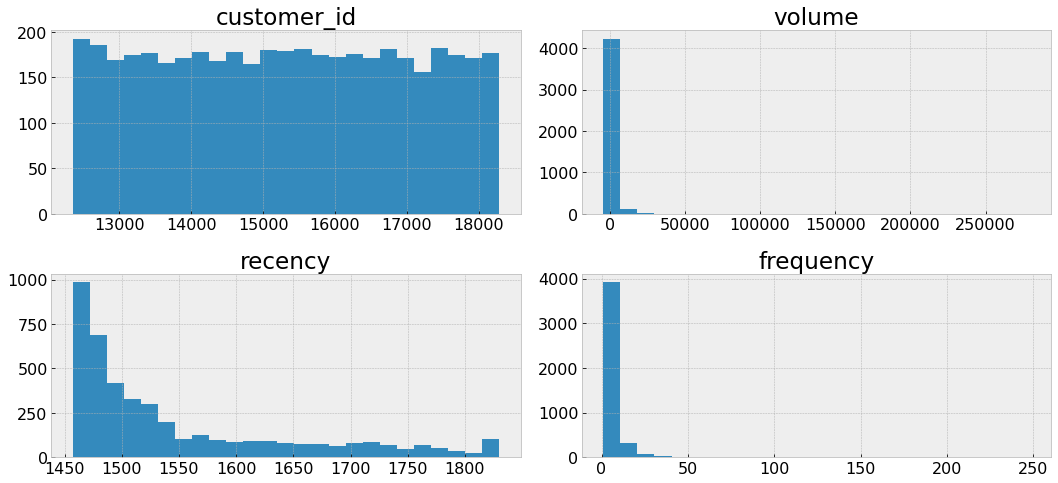

In [41]:
df4.hist(bins = 25);
plt.tight_layout()

<AxesSubplot:ylabel='frequency'>

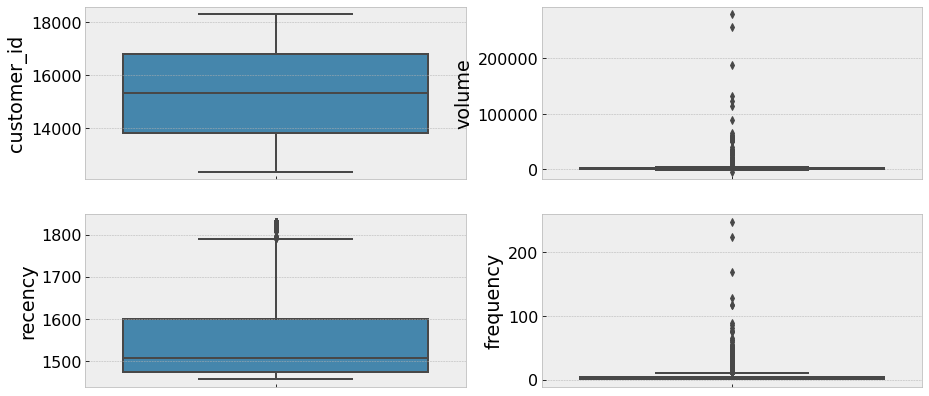

In [42]:
plt.subplot(2,2,1)
sns.boxplot(data = df4, y = 'customer_id')

plt.subplot(2,2,2)
sns.boxplot(data = df4, y = 'volume')

plt.subplot(2,2,3)
sns.boxplot(data = df4, y = 'recency')

plt.subplot(2,2,4)
sns.boxplot(data = df4, y = 'frequency')

## 4.2 Modelo RFM

In [101]:
df42 = df4.copy()

In [108]:
df42 = df42.sort_values('volume', ascending = False).reset_index(drop = True)
df42['m_score'] = 5-4*df42.index/len(df42)
# df42['m_score'] = df42['m_score'].apply(round)

df42 = df42.sort_values('recency').reset_index(drop = True)
df42['r_score'] = 5-4*df42.index/len(df42)
# df42['r_score'] = df42['r_score'].apply(round)

df42 = df42.sort_values('frequency', ascending = False).reset_index(drop = True)
df42['f_score'] = 5-4*df42.index/len(df42)
# df42['f_score'] = df42['f_score'].apply(round)

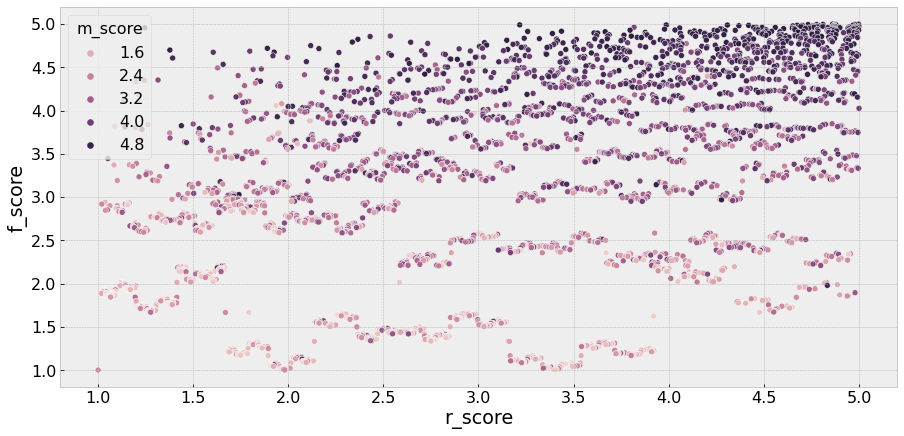

In [118]:
sns.scatterplot(data = df42, x = 'r_score', y = 'f_score', hue = 'm_score');

# 5 Preparação dos dados

In [43]:
df5 = df4.copy()

# 6 Seleção das features

In [44]:
df6 = df5.copy()

# 7 Ajuste fino dos hyperparâmetros

## Data checkpoint

In [48]:
df7 = df6.drop('customer_id', axis = 1)

In [50]:
df7 = df6.drop(['customer_id', 'last_date'], axis = 1)

In [5]:
df7.to_csv('../data/interim/c1_df7.csv', index = False)

In [4]:
df7 = pd.read_csv('../data/interim/c1_df7.csv')

## 7.1 Within-Cluster Sum of Square

In [52]:
X = df7.copy()

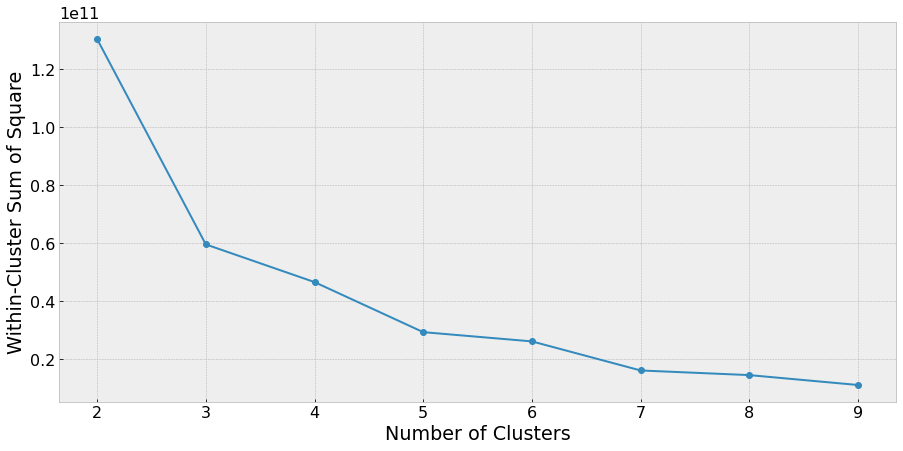

In [57]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9]
wss = eval_wss(X, clusters)
plt.plot(clusters, wss, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Square');

## 7.2 Silhouette Score

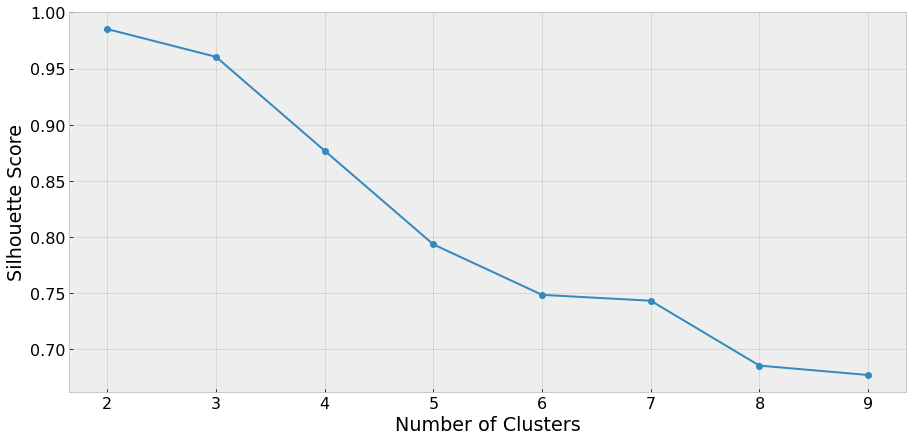

In [58]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9]
ss = eval_ss(X, clusters)
plt.plot(clusters, ss, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

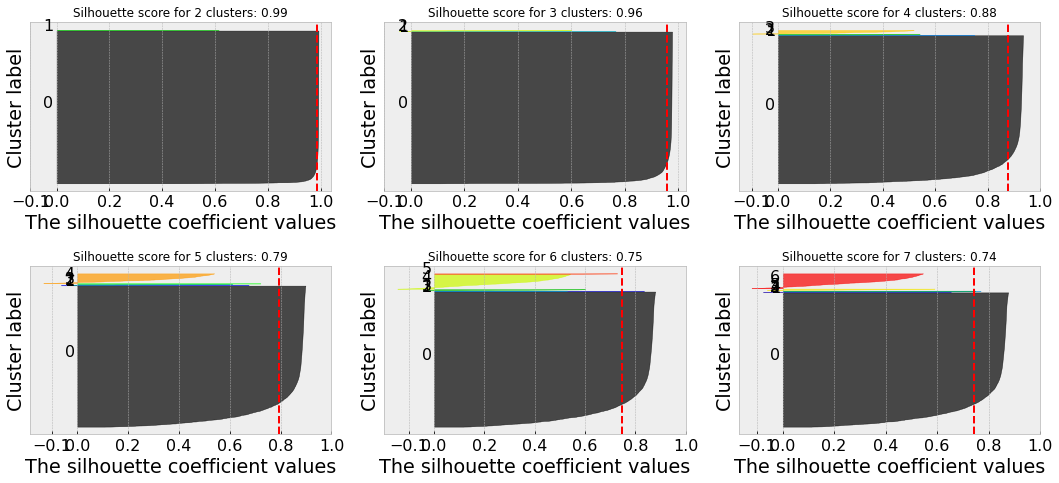

In [59]:
clusters = [2, 3, 4, 5, 6, 7]
grid_cols = 3
fig, axs = plt.subplots(2, grid_cols)
for i in range(len(clusters)):
    n_clusters = clusters[i]
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    r, c = divmod(i, grid_cols)
    for j in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / n_clusters)
        axs[r][c].fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          jth_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axs[r][c].text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axs[r][c].set_xlabel("The silhouette coefficient values")
    axs[r][c].set_ylabel("Cluster label")
    axs[r][c].set_title(
        'Silhouette score for {} clusters: {:.2f}'.format(n_clusters, silhouette_avg),
        fontsize = 12
    )

    # The vertical line for average silhouette score of all the values
    axs[r][c].axvline(x=silhouette_avg, color="red", linestyle="--")

    axs[r][c].set_yticks([]) # Clear the yaxis labels / ticks
    axs[r][c].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.tight_layout()

### 7.2.1 2-dimensional feature space

In [29]:
X = df7[['frequency', 'volume']].values

For n_clusters = 2 The average silhouette_score is : 0.986456603428084
For n_clusters = 3 The average silhouette_score is : 0.9634548998377547
For n_clusters = 4 The average silhouette_score is : 0.8857510340031115
For n_clusters = 5 The average silhouette_score is : 0.819069604483453
For n_clusters = 6 The average silhouette_score is : 0.7771002287109344


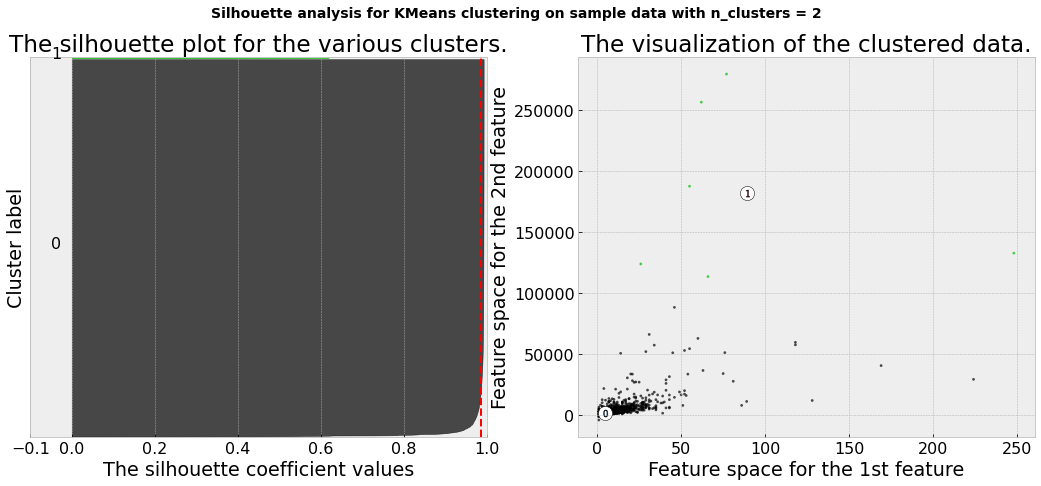

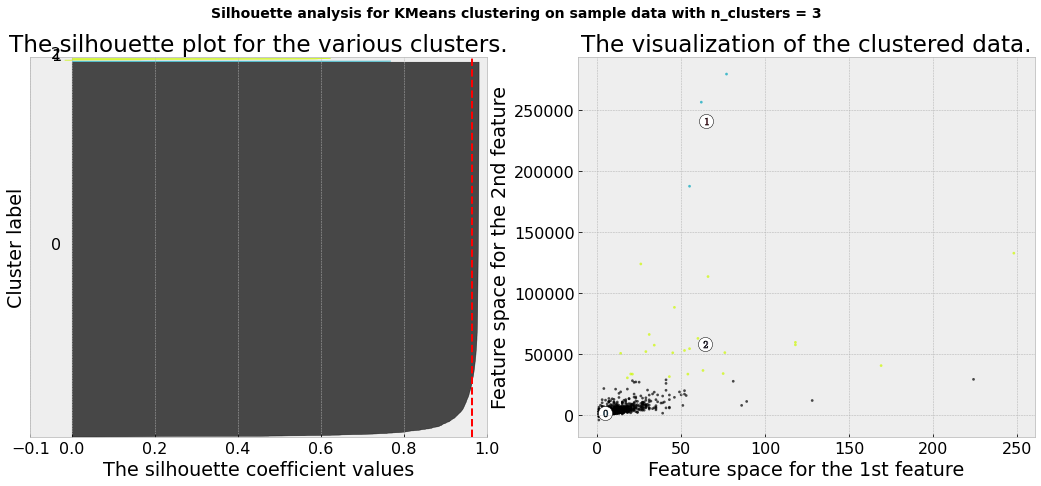

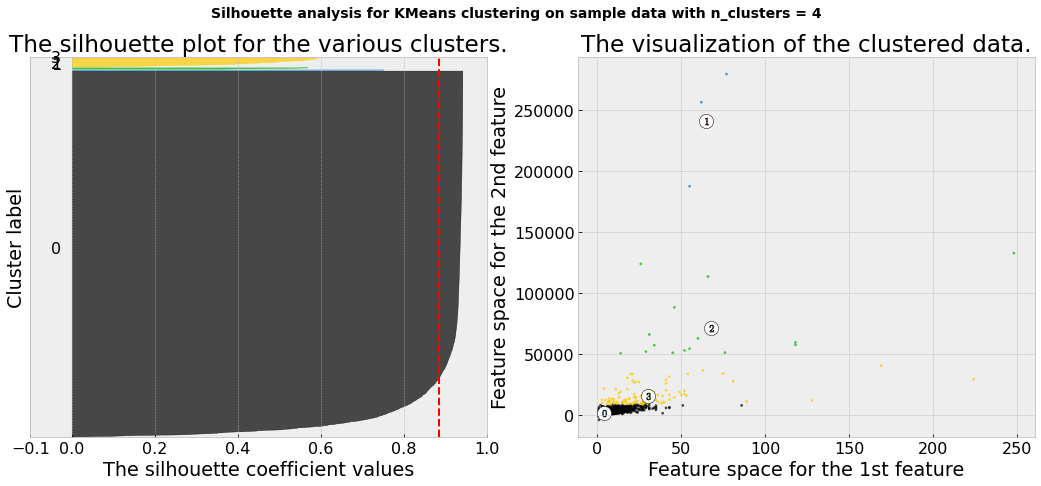

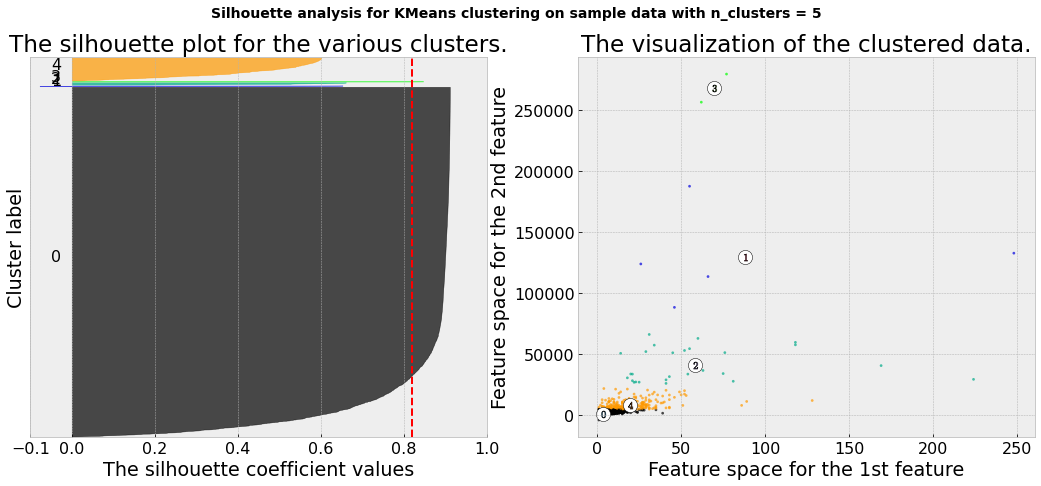

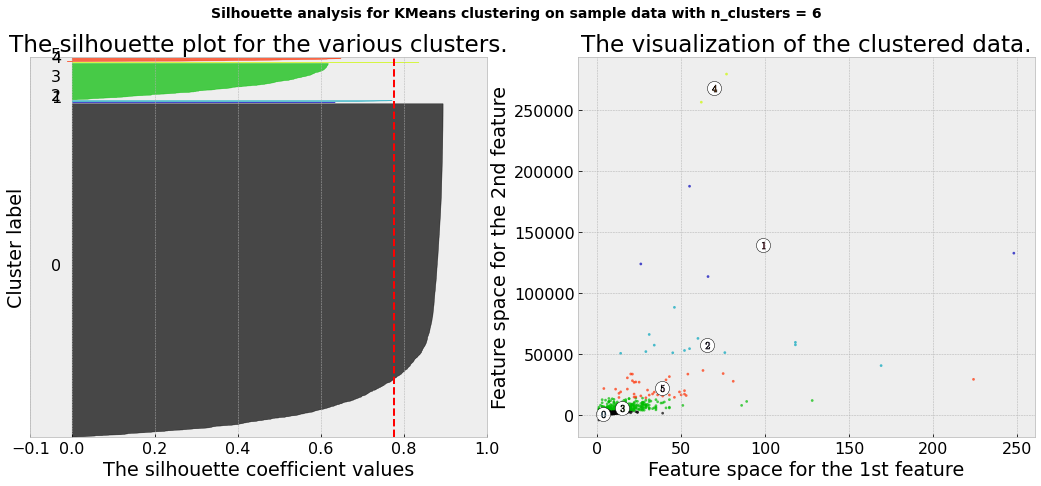

In [30]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )